In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import MESS
from MESS.util import set_params

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want the simulation output to life?
analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/full-parameter-estimation/"
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

In [19]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [32]:
r = MESS.Region("whole_enchilada")
## Region params
r.set_param("project_dir", analysis_dir)
r.set_param("generations", 0)
r.set_param("community_assembly_model", "*")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("alpha", (1000, 10000))

## Metacommunity Params
r.set_param("S_m", 250)
r.set_param("J_m", 5e4)
r.set_param("speciation_rate", 2)
r.set_param("death_proportion", 0.7)
r.set_param("trait_rate_meta", 2)
r.set_param("ecological_strength", (0.001, 1))

## Local Params
r.set_param("J", (1000, 10000))
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0005, 0.005))

r.write_params(full=True, force=True)
#r.run(sims=1000, ipyclient=ipyclient)

5985


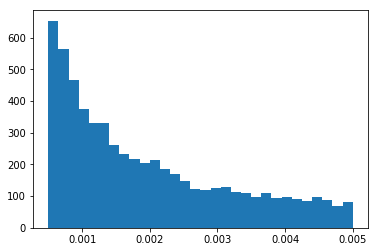

In [6]:

analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/figure5-sims/"
simfile = analysis_dir + "fig5_sims/SIMOUT.txt"

sim_df = pd.read_csv(simfile, sep="\t", header=0)
_, _, _ = plt.hist(sim_df["speciation_prob"], bins=30)
print(len(sim_df))

## An example of how to perform CV prediction and plot the results

Removed invariant targets. Retained: ['alpha', 'ecological_strength', 'J', 'm', 'generation', 'speciation_prob', '_lambda']
Cross validation prediction
                             MAE       RMSE    vscore        R2
alpha                2493.690172  66.338255  0.536092  0.529169
ecological_strength     0.234728   0.005782 -0.054110 -0.339803
J                    2627.017481  69.728094  0.712682  0.701570
m                       0.002420   0.000064  0.529077  0.443182
generation            438.079165  13.630741  0.812387  0.653898
speciation_prob         0.001246   0.000033  0.616387  0.565540
_lambda                 0.323027   0.008666  0.966597  0.961399
Cross validation scoring
Cross validation scores
[0.46963078 0.54147964 0.47765686 0.51282654 0.54876997]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aabe54bc310>,
      dtype=object)

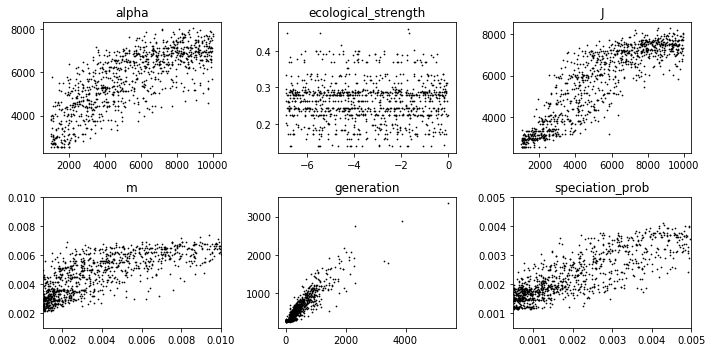

In [25]:
neut_rgr = MESS.inference.parameter_estimation_cv(simfile=simfile, algorithm='ab',\
                                                  target_model="neutral", quick=True, verbose=True)

_ = neut_rgr.plot_cv_predictions()

## CV parameter estimation by hand
You can also perform the parameter estimation cv by hand, but this requires a few more
steps, including creating a dummy empirical dataset (synthetic community), and calling
predict and score by hand. This is useful for testing.

In [33]:
## Ensemble class needs to be fed a df for the empirical data
## which is ignored by the cv routines, so here we just give
## it some dummy data.
tmp_com = MESS.util.synthetic_community()
neut_rgr = MESS.inference.Regressor(tmp_com, simfile, target_model="neutral", algorithm="rf", verbose=True)
neut_rgr.cross_val_predict(quick=True, verbose=True)
neut_rgr.cross_val_score(quick=True, verbose=True)
_ = neut_rgr.plot_cv_predictions()

Removed invariant targets. Retained: ['alpha', 'ecological_strength', 'J', 'm', 'generation', 'speciation_prob', '_lambda']

Estimator has not been optimized prior to CV. Performing estimator CV skipping
feature selection and hyperparameter optimization. For better performance call
predict() on the estimator prior to calling the cv_predict/cv_score methods.



array([0.6726884 , 0.66068994, 0.62896302, 0.62671927, 0.66313081])

## Running CV with varying target parameters
It's also possible to specify which data-types you'd like to use during the CV procedure, to investigate inference power based on the types of data you have from your empirical system. The base data axes are 'abundance', 'pi', 'dxy', and 'trait'. For example, if you only have abundance and genetic diversity from your local community you could run parameter estimation CV in the following way:

In [ ]:
neut_rgr = MESS.inference.parameter_estimation_cv(simfile=simfile, algorithm='ab',\
                                                  target_model="neutral", data_axes=["abundance", "pi"]\
                                                  quick=True, verbose=True)

_ = neut_rgr.plot_cv_predictions()

## Run CV prediction for all assembly models and all supported ensemble methods
This will take a while.

In [ ]:
cv_dir = analysis_dir + "cv_predict_results/"
if not os.path.exists(cv_dir):
    os.mkdir(cv_dir)

quick=False
verbose=False

for algorithm in ["ab", "gb", "rfq"]:
    for model in ["neutral", "filtering", "competition"]:
        !date
        print(algorithm, model)
        outdir = cv_dir + algorithm + "/"
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        try:
            rgr = MESS.inference.parameter_estimation_cv(simfile=simfile, algorithm=algorithm,\
                                                        target_model=model, quick=quick,\
                                                        verbose=verbose)

            rgr.dump(outfile=outdir + model + ".mdl")
            _ = rgr.plot_cv_predictions(outfile=outdir + model + "-cv.png")
            rgr.cv_stats.to_csv(outdir + model + "-stats.csv")
            display(rgr.cv_stats)
        except Exception as inst:
            print("Algorithm/model failed: {}/{}".format(algorithm, model))
            print(inst)
!date


Sat Jun  8 22:24:38 EDT 2019
('ab', 'neutral')


,MAE,RMSE,vscore,R2
alpha,2529.814230,47.159821,0.550470,0.548329
ecological_strength,0.203772,0.003690,-0.004891,-0.115928
J,2598.224792,48.428211,0.678662,0.675873
m,0.002326,0.000043,0.496185,0.471277
generation,417.109949,9.413142,0.802596,0.781890
speciation_prob,0.001216,0.000023,0.570161,0.554982
_lambda,0.332118,0.006296,0.967886,0.966385


Sat Jun  8 23:01:50 EDT 2019
('ab', 'filtering')


,MAE,RMSE,vscore,R2
alpha,2529.812383,46.717698,0.416548,0.413926
ecological_strength,0.204131,0.003985,0.157657,0.098510
J,2523.695651,46.759438,0.440494,0.437278
m,0.002261,0.000042,0.300701,0.286482
generation,91.500700,2.792412,0.475676,0.466794
speciation_prob,0.001155,0.000022,0.395981,0.377391
_lambda,0.292949,0.005355,0.395137,0.391517


Sat Jun  8 23:24:26 EDT 2019
('ab', 'competition')


,MAE,RMSE,vscore,R2
alpha,2443.322178,47.691578,0.406992,0.404221
ecological_strength,0.202139,0.004310,0.307366,0.288239
J,2562.265545,50.109860,0.481944,0.481352
m,0.002260,0.000044,0.239893,0.233249
generation,50.171307,1.333714,0.558735,0.554531
speciation_prob,0.001121,0.000022,0.425936,0.420071
_lambda,0.307101,0.006121,0.705469,0.700974


Sat Jun  8 23:45:47 EDT 2019
('gb', 'neutral')
  NB: No features found relevant for target ecological_strength
      Fall back to using all parameters.


,MAE,RMSE,vscore,R2
alpha,2704.838494,50.881561,0.679679,0.679679
ecological_strength,0.173560,0.003627,-0.068334,-0.069575
J,2778.866425,52.269133,0.852912,0.852912
m,0.002417,0.000047,0.678905,0.678892
generation,419.173181,9.507299,0.879097,0.879090
speciation_prob,0.001214,0.000024,0.713170,0.713164
_lambda,0.328240,0.006236,0.981510,0.981509


Sun Jun  9 05:30:54 EDT 2019
('gb', 'filtering')


,MAE,RMSE,vscore,R2
alpha,2661.030582,49.832685,0.510581,0.510581
ecological_strength,0.183828,0.003981,0.191985,0.191733
J,2640.956248,49.686956,0.578363,0.578361
m,0.002322,0.000045,0.460891,0.460867
generation,88.793590,2.740976,0.633143,0.633135
speciation_prob,0.001154,0.000022,0.477789,0.477787
_lambda,0.315199,0.005916,0.598896,0.598873


Sun Jun  9 10:01:45 EDT 2019
('gb', 'competition')


,MAE,RMSE,vscore,R2
alpha,2488.832988,49.179742,0.492691,0.492691
ecological_strength,0.191670,0.004445,0.445643,0.445641
J,2620.657822,51.515358,0.595189,0.595180
m,0.002264,0.000046,0.372345,0.372325
generation,49.576771,1.363615,0.693478,0.693475
speciation_prob,0.001142,0.000023,0.558569,0.558568
_lambda,0.311495,0.006197,0.775030,0.775030


Sun Jun  9 14:00:03 EDT 2019
('rfq', 'neutral')
  NB: No features found relevant for target ecological_strength
      Fall back to using all parameters.
